In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow
import typeguard
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout,Flatten,Dense,Activation,MaxPool2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K
from typeguard import typechecked
from typing import Optional

Menyesuaikan proses memuat dgn beban kerja dan sumber daya 

In [103]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

AUGMENTASI

In [104]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split = 0.2,
                                rotation_range=5,
                                width_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

Generator Train

In [105]:
train_dataset = train_datagen.flow_from_directory(directory = 'D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/train/',
                target_size = (224,224),
                class_mode = 'categorical',
                subset = 'training',
                batch_size = 64)

Found 3296 images belonging to 6 classes.


Generator Validasi

In [106]:
valid_dataset = valid_datagen.flow_from_directory (directory = 'D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/val/',
                target_size = (224,224),
                class_mode = 'categorical',
                subset = 'validation',
                batch_size = 64)

Found 173 images belonging to 6 classes.


Generator test

In [107]:
test_dataset = test_datagen.flow_from_directory (directory = 'D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/test/',
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = 64)

Found 888 images belonging to 6 classes.


In [108]:
base_model = MobileNet(input_shape=(224,224,3),
            include_top=False,
            weights="imagenet")

In [109]:
for layer in base_model.layers:
    layer.trainable = False

Membangun Model

In [110]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))

In [111]:
model.summary

<bound method Model.summary of <Sequential name=sequential_4, built=False>>

F1 Score

In [112]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [113]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

In [114]:
def exponential_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01,5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [115]:
model.compile(optimizer='rmsprop', 
loss='categorical_crossentropy',metrics = METRICS)

In [117]:
history = model.fit(train_dataset,
                    validation_data = valid_dataset,
                    epochs = 50,
                    verbose = 1,
                    callbacks=lr_scheduler)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.8526 - auc: 0.8775 - f1_score: 0.4079 - loss: 1.0805 - precision: 0.6163 - recall: 0.3060 - val_accuracy: 0.8748 - val_auc: 0.9175 - val_f1_score: 0.5685 - val_loss: 0.8950 - val_precision: 0.6667 - val_recall: 0.4971 - learning_rate: 0.0100
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8575 - auc: 0.8922 - f1_score: 0.4442 - loss: 1.0120 - precision: 0.6361 - recall: 0.3391 - val_accuracy: 0.8719 - val_auc: 0.9222 - val_f1_score: 0.5661 - val_loss: 0.8413 - val_precision: 0.6493 - val_recall: 0.5029 - learning_rate: 0.0063
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8612 - auc: 0.8986 - f1_score: 0.4844 - loss: 0.9775 - precision: 0.6356 - recall: 0.3914 - val_accuracy: 0.8892 - val_auc: 0.9248 - val_f1_score: 0.6254 - val_loss: 0.8481 - val_precision: 0.7042 - val_recall: 0.5780 - learning_rate: 0.0040
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8612 - auc: 0.

In [94]:
#%% PLOTTING RESULTS (Train vs Validation Folder 1)

def Train_Val_plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(20,5))
    fig.suptitle("VISUALIZE THE PERFORMANCE MATRICS")

    ax1.plot(range(1,len(acc)+1),acc)
    ax1.plot(range(1,len(val_acc)+ 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1,len(loss)+1),loss)
    ax2.plot(range(1,len(val_loss)+ 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) +1),auc)
    ax3.plot(range(1,len(val_auc) +1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision)+1), precision)
    ax4.plot(range(1, len(val_precision) +1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1)+1), f1)
    ax5.plot(range(1, len(val_f1) +1), val_f1)
    ax5.set_title('History of f1_score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend(['training', 'validation'])
    plt.show

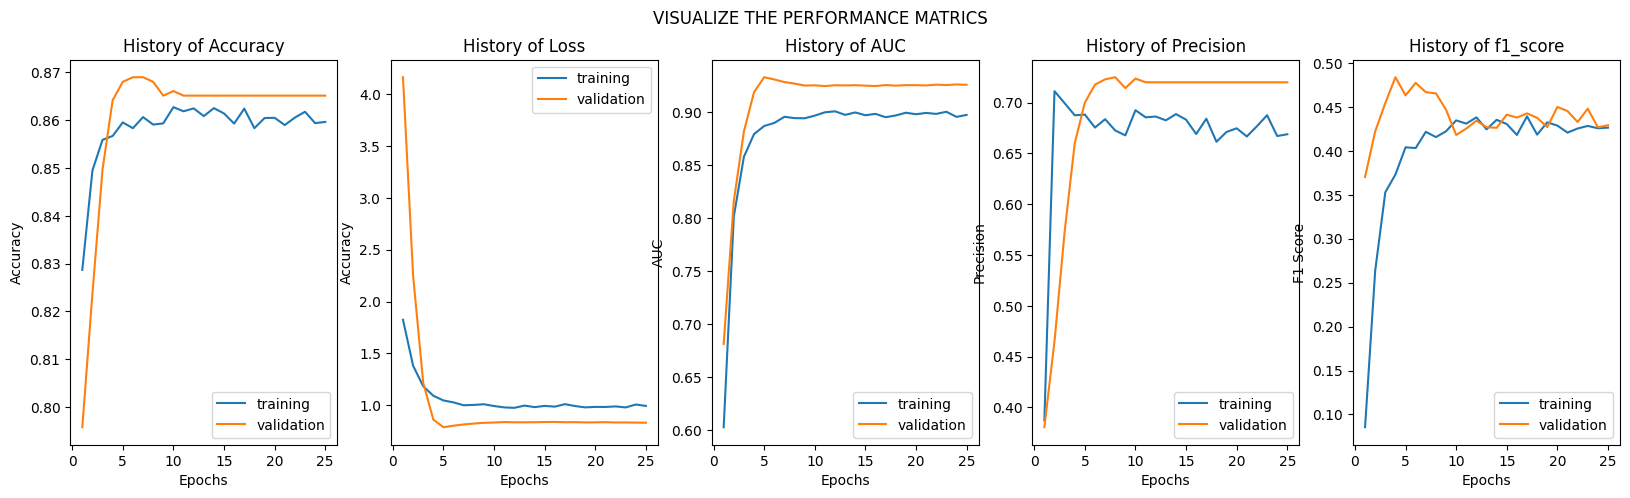

In [95]:
Train_Val_plot(history.history['accuracy'],history.history['val_accuracy'],
                history.history['loss'],history.history['val_loss'],
                history.history['auc'],history.history['val_auc'],
                history.history['precision'],history.history['val_precision'],
                history.history['f1_score'],history.history['val_f1_score'])

In [96]:
scores = model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8684 - auc: 0.9428 - f1_score: 0.4633 - loss: 0.7410 - precision: 0.7200 - recall: 0.3444


In [97]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.8691815733909607
Precision =  0.7301204800605774
Recall =  0.34121620655059814
AUC =  0.939125120639801
F1_score =  0.46247032284736633


In [98]:
model.save('mobilenetv2_custom_model5.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (1, 6)
Predicted class: Buras


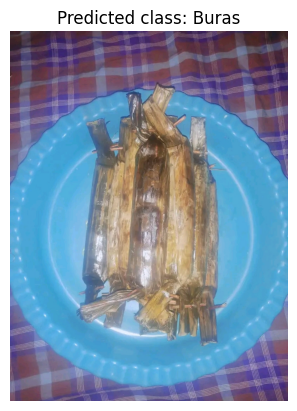

In [100]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Load the custom MobileNetV2 model
model = load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\mobilenetv2_custom_model.h5")

# Define the class names
class_names = ['Buras', 'Dangkot', 'Gogos', 'Kapurung', 'Sokko', 'Sop Konro']

# Define the path to your image
image_path = r"E:\Dataset\Gogos\1715183308117.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran dengan ukuran input model Anda
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make prediction
preds = model.predict(x)

# Check the shape of the predictions
print("Predictions shape:", preds.shape)

# Get the index of the highest probability prediction
pred_index = np.argmax(preds)

# Initialize the predicted class variable
predicted_class = "Predicted index is out of range"

# Check if pred_index is within the range of class_names
if pred_index < len(class_names):
    # Get the predicted class label
    predicted_class = class_names[pred_index]

# Print the predicted class label
print("Predicted class:", predicted_class)

# Display the image along with the predicted class
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()
